   CustomerID  Gender  Age  Annual Income (k$)  Spending Score (1-100)
0           1    Male   19                  15                      39
1           2    Male   21                  15                      81
2           3  Female   20                  16                       6
3           4  Female   23                  16                      77
4           5  Female   31                  17                      40
       CustomerID         Age  Annual Income (k$)  Spending Score (1-100)
count  200.000000  200.000000          200.000000              200.000000
mean   100.500000   38.850000           60.560000               50.200000
std     57.879185   13.969007           26.264721               25.823522
min      1.000000   18.000000           15.000000                1.000000
25%     50.750000   28.750000           41.500000               34.750000
50%    100.500000   36.000000           61.500000               50.000000
75%    150.250000   49.000000           78.000000       

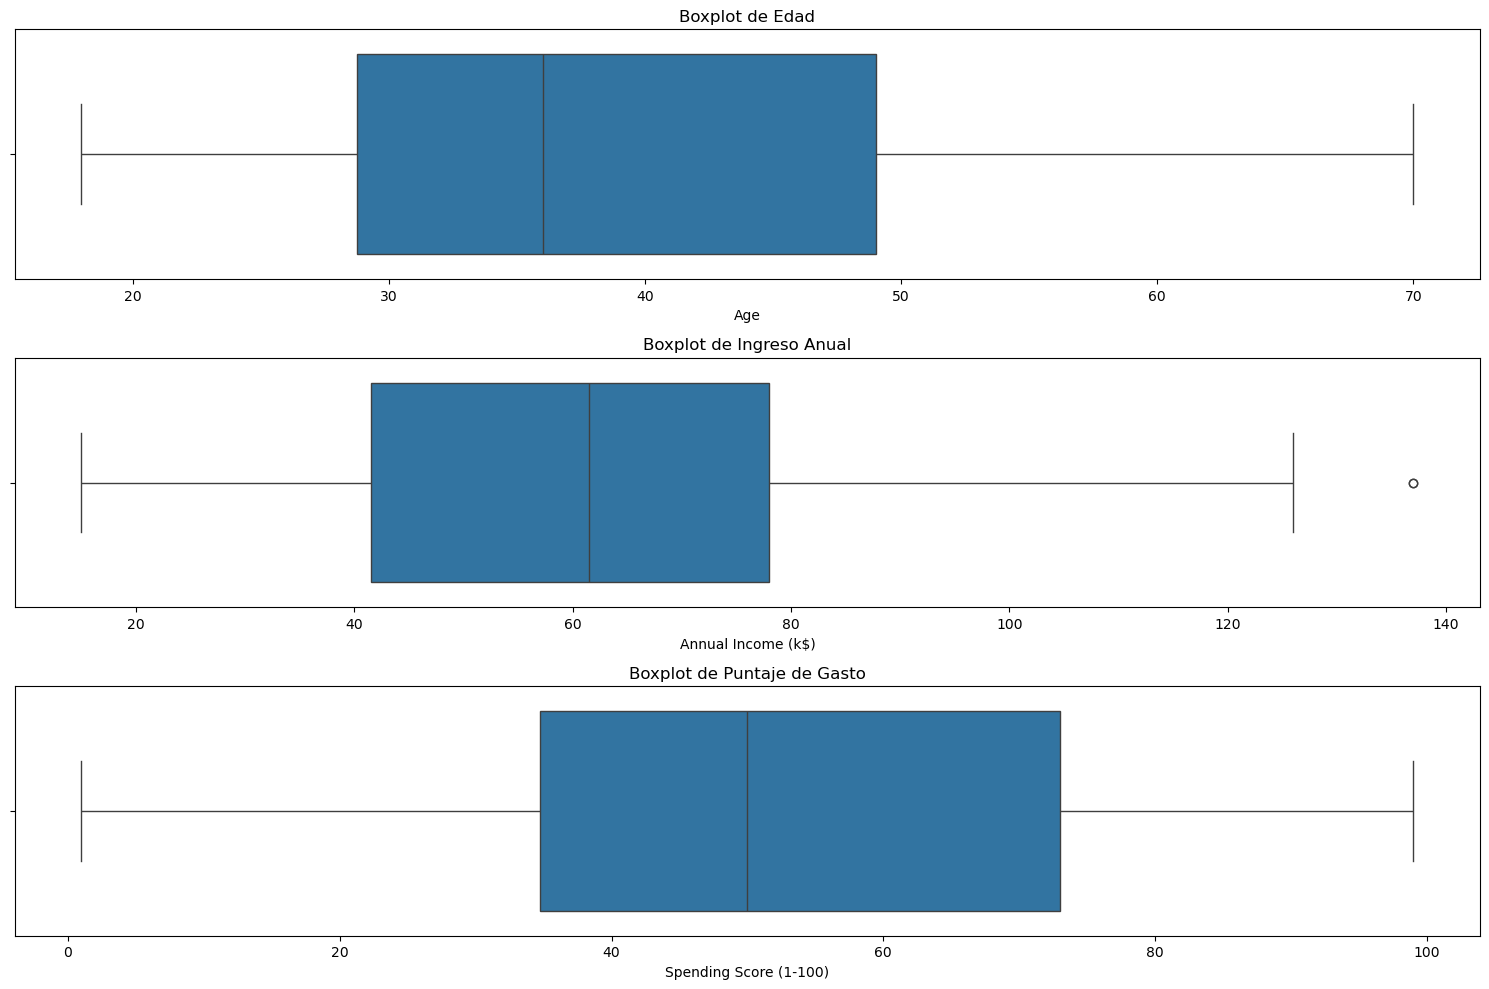

Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64
Características seleccionadas: Index(['Gender', 'Age', 'Annual Income (k$)'], dtype='object')


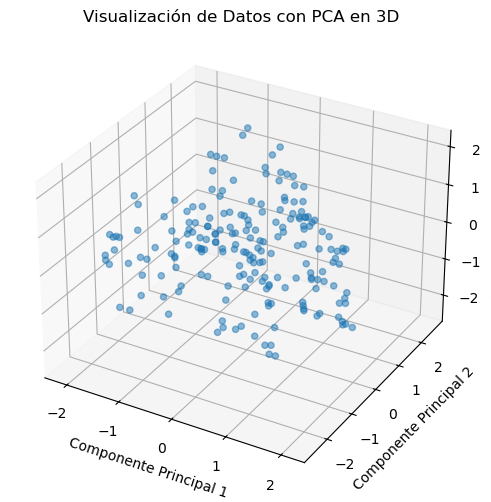

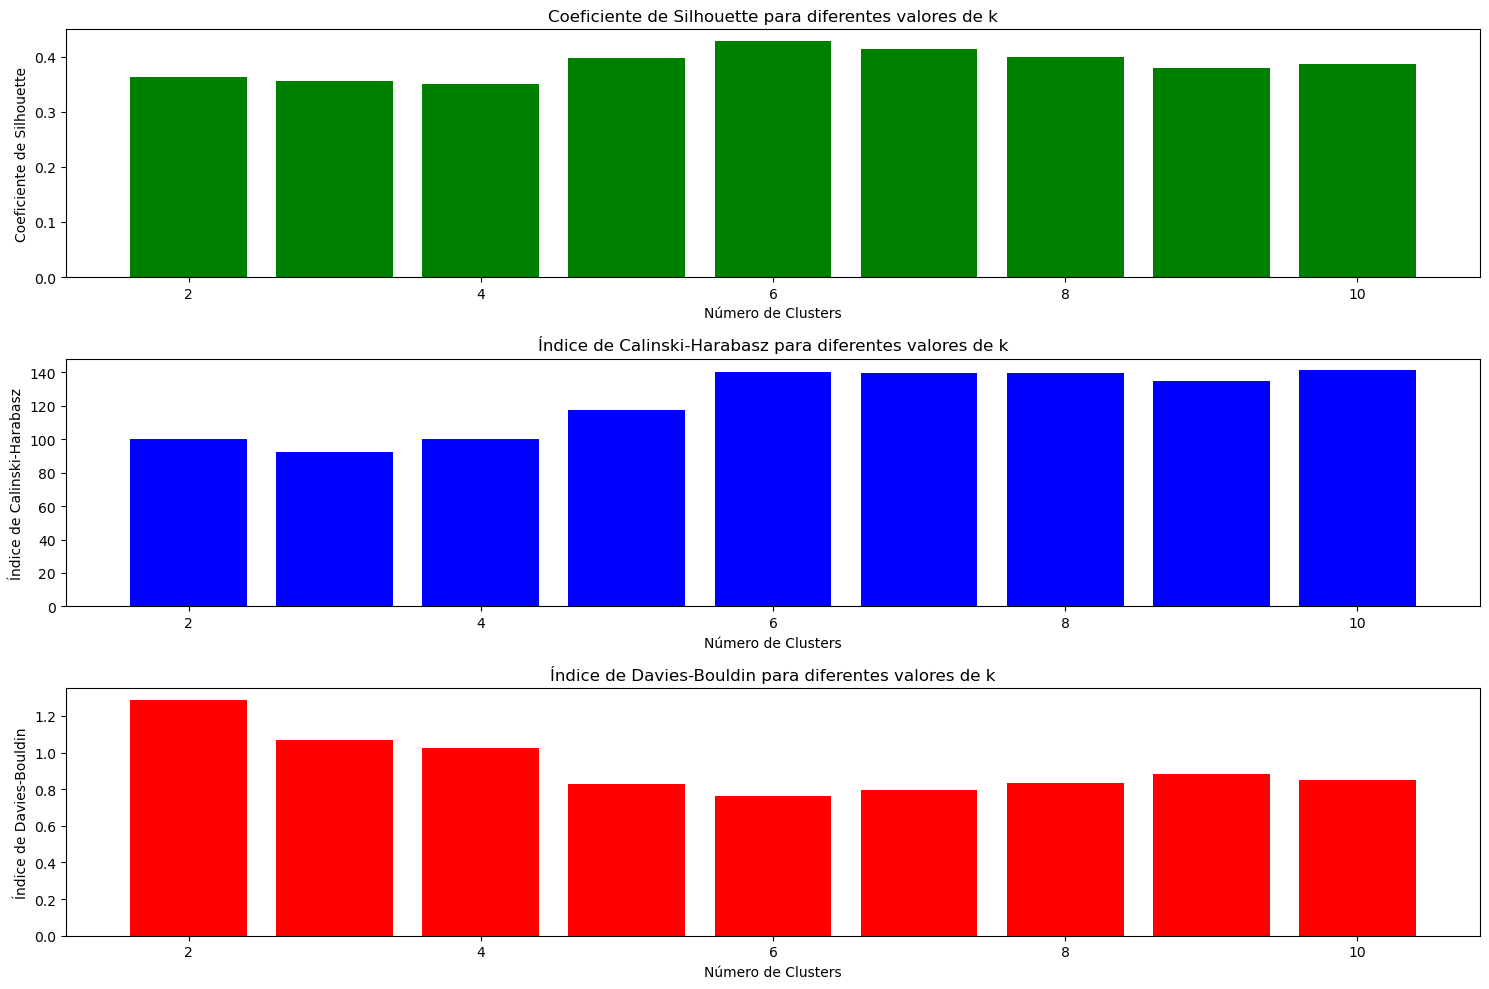

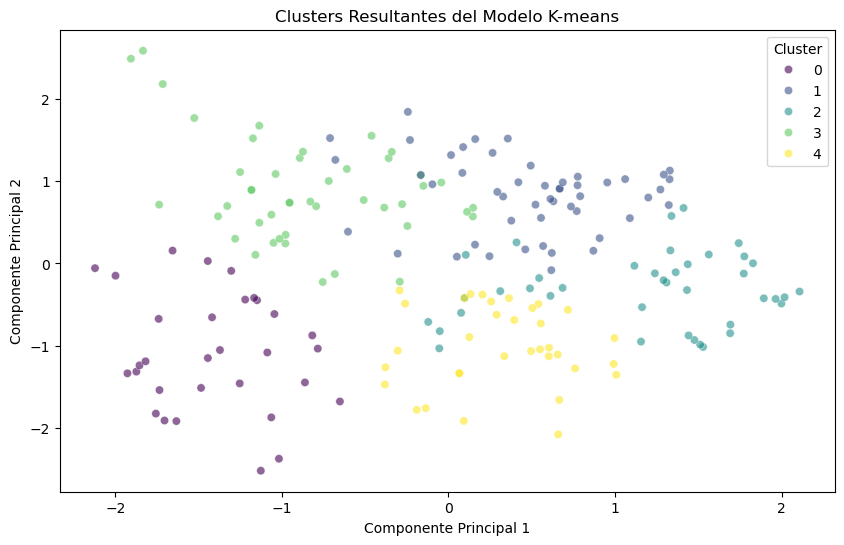

         Gender        Age  Annual Income (k$)  Spending Score (1-100)
Cluster                                                               
0           0.0  57.806452           54.193548               36.645161
1           1.0  33.580000           81.360000               54.480000
2           0.7  27.400000           29.175000               60.750000
3           0.0  31.000000           77.888889               52.155556
4           1.0  53.176471           49.764706               41.264706

Se realizaron las siguientes mejoras:
1. Se ajustaron los hiperparámetros del modelo K-means: init='k-means++', n_init=10, max_iter=300.
2. Se añadieron métricas adicionales de evaluación: índice de Davies-Bouldin.
3. Se realizó un análisis de outliers utilizando el método z-score.
4. Se utilizó Recursive Feature Elimination (RFE) para la selección de características relevantes.
5. Se realizó una visualización 3D de los componentes principales obtenidos mediante PCA.
6. Se utilizaron gráficos de b

In [1]:
# Importar librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from scipy import stats
import os
import warnings

# Configuración para evitar múltiples advertencias
warnings.filterwarnings('ignore')

# Paso 1: Análisis exploratorio de los datos
# Carga del dataset
data = pd.read_csv('Mall_Customers.csv')

# Mostrar las primeras filas del dataset
print(data.head())

# Descripción del dataset para observar tendencias y distribuciones
print(data.describe())

# Identificación de valores nulos y tipos de datos
print(data.info())

# Visualización de outliers mediante boxplots para cada variable
plt.figure(figsize=(15, 10))
plt.subplot(3, 1, 1)
sns.boxplot(x=data['Age'])
plt.title('Boxplot de Edad')

plt.subplot(3, 1, 2)
sns.boxplot(x=data['Annual Income (k$)'])
plt.title('Boxplot de Ingreso Anual')

plt.subplot(3, 1, 3)
sns.boxplot(x=data['Spending Score (1-100)'])
plt.title('Boxplot de Puntaje de Gasto')

plt.tight_layout()
plt.show()

# Paso 2: Preprocesamiento de los datos
# Eliminación de columnas irrelevantes ('CustomerID')
data = data.drop(columns=['CustomerID'])

# Codificación de la variable categórica 'Gender' en valores numéricos
data['Gender'] = data['Gender'].map({'Male': 0, 'Female': 1})

# Identificación de valores faltantes
print(data.isnull().sum())

# Análisis y eliminación de outliers utilizando el método z-score
z_scores = np.abs(stats.zscore(data))
data = data[(z_scores < 3).all(axis=1)]

# Paso 3: Selección de Características
# Selección de características utilizando Recursive Feature Elimination (RFE)
X = data.drop(columns=['Spending Score (1-100)'])
y = data['Spending Score (1-100)']
model = LinearRegression()
selector = RFE(model, n_features_to_select=3)
X_new = selector.fit_transform(X, y)
selected_features = X.columns[selector.get_support()]
print(f"Características seleccionadas: {selected_features}")

# Escalado de las variables numéricas
scaler = StandardScaler()
data_scaled = scaler.fit_transform(X_new)

# Paso 4: Reducción de Dimensionalidad con PCA
# Aplicación de PCA para reducir la dimensionalidad
pca = PCA(n_components=3)
data_pca = pca.fit_transform(data_scaled)

# Visualización de los resultados de PCA en 3D
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data_pca[:, 0], data_pca[:, 1], data_pca[:, 2], alpha=0.5)
ax.set_xlabel('Componente Principal 1')
ax.set_ylabel('Componente Principal 2')
ax.set_zlabel('Componente Principal 3')
plt.title('Visualización de Datos con PCA en 3D')
plt.show()

# Paso 5: Entrenamiento del modelo K-means
# Ajuste de la variable de entorno para evitar problemas de fuga de memoria en Windows con MKL
os.environ['OMP_NUM_THREADS'] = '1'

# Inicialización del modelo con diferentes números de clusters para identificar el óptimo
inertia = []
silhouette_scores = []
calinski_harabasz_scores = []
davies_bouldin_scores = []
range_clusters = range(2, 11)
for k in range_clusters:
    kmeans = KMeans(n_clusters=k, random_state=42, init='k-means++', n_init=10, max_iter=300)
    kmeans.fit(data_pca)
    inertia.append(kmeans.inertia_)
    labels = kmeans.labels_
    silhouette_scores.append(silhouette_score(data_pca, labels))
    calinski_harabasz_scores.append(calinski_harabasz_score(data_pca, labels))
    davies_bouldin_scores.append(davies_bouldin_score(data_pca, labels))

# Gráficos de barras para evaluar las diferentes métricas de clustering
plt.figure(figsize=(15, 10))

plt.subplot(3, 1, 1)
plt.bar(range_clusters, silhouette_scores, color='green')
plt.xlabel('Número de Clusters')
plt.ylabel('Coeficiente de Silhouette')
plt.title('Coeficiente de Silhouette para diferentes valores de k')

plt.subplot(3, 1, 2)
plt.bar(range_clusters, calinski_harabasz_scores, color='blue')
plt.xlabel('Número de Clusters')
plt.ylabel('Índice de Calinski-Harabasz')
plt.title('Índice de Calinski-Harabasz para diferentes valores de k')

plt.subplot(3, 1, 3)
plt.bar(range_clusters, davies_bouldin_scores, color='red')
plt.xlabel('Número de Clusters')
plt.ylabel('Índice de Davies-Bouldin')
plt.title('Índice de Davies-Bouldin para diferentes valores de k')

plt.tight_layout()
plt.show()

# Paso 6: Selección del número óptimo de clusters
# Selección del número óptimo de clusters basado en las gráficas anteriores
optimal_k = 5

# Entrenamiento del modelo K-means con el número óptimo de clusters
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, init='k-means++', n_init=10, max_iter=300)
kmeans_final.fit(data_pca)

# Agregar las etiquetas de cluster al dataframe original
data['Cluster'] = kmeans_final.labels_

# Visualización de los clusters resultantes
plt.figure(figsize=(10, 6))
sns.scatterplot(x=data_pca[:, 0], y=data_pca[:, 1], hue=data['Cluster'], palette='viridis', alpha=0.6)
plt.title('Clusters Resultantes del Modelo K-means')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.legend(title='Cluster')
plt.show()

# Paso 7: Interpretación de los clusters
# Cálculo de estadísticas descriptivas para cada cluster
cluster_summary = data.groupby('Cluster').mean()
print(cluster_summary)

# Resumen de mejoras aplicadas
print("\nSe realizaron las siguientes mejoras:")
print("1. Se ajustaron los hiperparámetros del modelo K-means: init='k-means++', n_init=10, max_iter=300.")
print("2. Se añadieron métricas adicionales de evaluación: índice de Davies-Bouldin.")
print("3. Se realizó un análisis de outliers utilizando el método z-score.")
print("4. Se utilizó Recursive Feature Elimination (RFE) para la selección de características relevantes.")
print("5. Se realizó una visualización 3D de los componentes principales obtenidos mediante PCA.")
print("6. Se utilizaron gráficos de barras para comparar las métricas de evaluación de los clusters.")
